# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass
from HANKmodel_baseline import HANKModelClass_baseline

# Setup

In [2]:
#print(model)
model = HANKModelClass(name='two_sector')
model_baseline = HANKModelClass_baseline(name='one_sector')
model.print_unpack_varlist()

    for ncol in range(ncols):

        # unpack
        A = path.A[ncol,:]
        B = path.B[ncol,:]
        C = path.C[ncol,:]
        C_N = path.C_N[ncol,:]
        C_L = path.C_L[ncol,:]
        clearing_A = path.clearing_A[ncol,:]
        clearing_C = path.clearing_C[ncol,:]
        clearing_C_N = path.clearing_C_N[ncol,:]
        clearing_C_L = path.clearing_C_L[ncol,:]
        clearing_N = path.clearing_N[ncol,:]
        d = path.d[ncol,:]
        d_N = path.d_N[ncol,:]
        d_L = path.d_L[ncol,:]
        G = path.G[ncol,:]
        i = path.i[ncol,:]
        N = path.N[ncol,:]
        N_N = path.N_N[ncol,:]
        N_L = path.N_L[ncol,:]
        M_N = path.M_N[ncol,:]
        M_L = path.M_L[ncol,:]
        pm_L = path.pm_L[ncol,:]
        pm_N = path.pm_N[ncol,:]
        NKPC_res_N = path.NKPC_res_N[ncol,:]
        NKPC_res_L = path.NKPC_res_L[ncol,:]
        p_N = path.p_N[ncol,:]
        p_L = path.p_L[ncol,:]
        pi = path.pi[ncol,:]
        pi_N = path.pi_N[ncol,:]
  

# Step 1: Steady state

### Two-sector main model

In [3]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

model.find_ss(do_print=True)
model.compute_jacs(do_print=False)

steady state found in 21.4 secs
 Q   =   0.7189
 P   =   0.8105
 Z_N   =   0.3018
 Z_L   =   1.0441
 M_N   =   0.2949
 M_L   =   0.0960
 N_L   =   0.4173
 N_N   =   0.5234
 HH_ell   =   1.1211
 wage N  =   0.3131
 wage L  =   0.4356
 par.varphi   =   1.0000
 par.beta   =   0.9706
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =   0.00000000
Discrepancy in N =   0.00000000


#### Tests

In [ ]:
'''
# HH Transition path
model.test_hh_path()
#Full transition path
model.test_path()
#Show Jacobians
model.test_jacs(s_list=[50,100,150])
'''

## Steady state characteristics:

In [ ]:
print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average Subsistence share of expenditures (in the data = 22.4%) = {(par.c_bar/(ss.P*ss.C)):8.4f}')
print(f'Lowest income household subsistence share of expenditures (in the data = 43,5%) = {(par.c_bar/(ss.P*np.average(ss.c[0,0,0]))):8.4f}')
print(f'Average expenditures share on necessities for the lowest income households (in the data = 70.5%): = {(np.average(ss.c_N[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 33.2%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')
print(f'wage share, necessities production: (in the data = 37.3%) = {(ss.N_N*ss.w_N/(ss.M_N*ss.pm_N+ss.N_N*ss.w_N)):8.4f}')
print(f'wage share, luxuries production: (in the data =69.2%) = {(ss.N_L*ss.w_L/(ss.M_L*ss.pm_L+ss.N_L*ss.w_L)):8.4f}')

MPCs for different values of Chi and c_bar

In [ ]:
'''
model_MPC = model.copy()

c_bar_list = [0.0, 0.025, 0.05, 0.075, 0.10]
chi_list = [0.0, 0.025, 0.05, 0.075, 0.10]

MPC_matrix = np.empty(shape=(len(c_bar_list),len(chi_list)))

for i,c_bar in enumerate(c_bar_list):
    model_MPC.par.c_bar = c_bar
    
    for j,chi in enumerate(chi_list):
        model_MPC.par.chi = chi
        
        model_MPC.find_ss()

        model_MPC.MPC = np.zeros(model_MPC.ss.D.shape)
        m_diff = (1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,1:]-(1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,:-1]
        model_MPC.MPC[:,:,:-1] = (model_MPC.ss.c[:,:,1:]-model_MPC.ss.c[:,:,:-1])/m_diff
        model_MPC.MPC[:,:,-1] = model_MPC.MPC[:,:,-1] # assuming constant MPC at end
        model_MPC.mean_MPC = np.sum(model_MPC.MPC*model_MPC.ss.D)
        model_MPC.mean_MPC_ann = 1-(1-model_MPC.mean_MPC)**4
        MPC_matrix[j,i] = model_MPC.mean_MPC_ann
        print(f'mean MPC - c_bar = {c_bar:.3f}, chi = {chi:.3f} : {model_MPC.mean_MPC:.3f} [annual: {model_MPC.mean_MPC_ann:.3f}]')

df_mpc = pd.DataFrame(MPC_matrix, columns=c_bar_list, index=chi_list)
print(df_mpc.to_latex())
'''

Steady state values

In [ ]:
var_list = ['Y','N','M','mc','d','C','w','pm'] 
var_dict = vars(ss)
var_dict_baseline = vars(model_baseline.ss)
values_N = [round(var_dict[i+'_N'],3) for i in var_list]
values_L = [round(var_dict[i+'_L'],3) for i in var_list]
values_baseline = [round(var_dict_baseline[i],3) for i in var_list]
ss_values_df = pd.DataFrame(list(zip(values_baseline,values_N,values_L)), columns=['One-Sector','Sector N','Sector L'], index=var_list)
print(ss_values_df.to_latex())


Steady State graphs

In [ ]:
a_max = 500

MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'Mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')


fig = plt.figure(figsize=(5*3,2*4),dpi=750)

# a. income/productivity
ax = fig.add_subplot(2,3,1)
ax.set_title('Productivity')
y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])
ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(2,3,2)
ax.set_title('Savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. MPC
I = par.a_grid < a_max
ax = fig.add_subplot(2,3,3)
ax.set_title('Marginal Propensity to Consume')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],MPC[0,i_z,I],label=f'Individual Productivity = {i_z}')
ax.legend(frameon=True,prop={'size': 15})
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC$')
ax.set_xscale('symlog')

# D. labor supply
I = par.a_grid < a_max
ax = fig.add_subplot(2,3,4)
ax.set_title('Labor Supply')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'Individual Productivity = {i_z}')
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')
#ax.set_xscale('symlog')

# a. necessity consumption share
I = model.par.a_grid < a_max
ax = fig.add_subplot(2,3,5)
ax.set_title('Consumption Share (Necessities)')
for i_z in [0,model.par.Nz//2,model.par.Nz-1]:
    ax.plot(model.par.a_grid[I],model.ss.c_N[0,i_z,I]/(model.ss.P*model.ss.c[0,i_z,I]),label=f'i_z = {i_z}')
#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')
#ax.set_xscale('symlog')

# a. luxury consumption share
I = model.par.a_grid < a_max
ax = fig.add_subplot(2,3,6)
ax.set_title('Consumption Share (Luxuries)')
for i_z in [0,model.par.Nz//2,model.par.Nz-1]:
    ax.plot(model.par.a_grid[I],model.ss.Q*model.ss.c_L[0,i_z,I]/(model.ss.P*model.ss.c[0,i_z,I]),label=f'i_z = {i_z}')

#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')
#ax.set_xscale('symlog')

fig.tight_layout()

# Step 3a: Find non-linear transition path

## Plot transitions

## Find transition path 1 - Monetary Policy shock

In [4]:
### 2 sector MP shock ###
par.jump_istar = 0.0025 # 25 BP Monetary policy shock
par.jump_pm_N     = 0.0 # cost push shock
model.find_transition_path(do_print=False) #all

paths_hh = ['i','pm_N','pi','r','ELL_hh','C_hh','C_N_hh','C_L_hh','Q','tau','w_N']
hh_names = ['Nominal Interest Rate','Inflation','Real Interest Rate','Relative Price','Labor Supply','Consumption','Necessity Consumption','Luxury Consumption','Tax Rate','Wage, N']
paths_firms =['pi_N','pi_L','N_N','N_L','M_N','M_L','d_N','d_L']
firms_names = ['Inflation, N','Inflation, L','Labor, N','Labor, L','Materials, N','Materials, L','Dividends, N','Dividends, L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push

### Push shock ###
model_push = model.copy()
model_push.par.jump_istar = 0.00 # 25 BP Monetary policy shock
model_push.par.jump_pm_N     = 0.01*model_push.ss.Q # cost push shock
model_push.find_transition_path()


### varnames ###


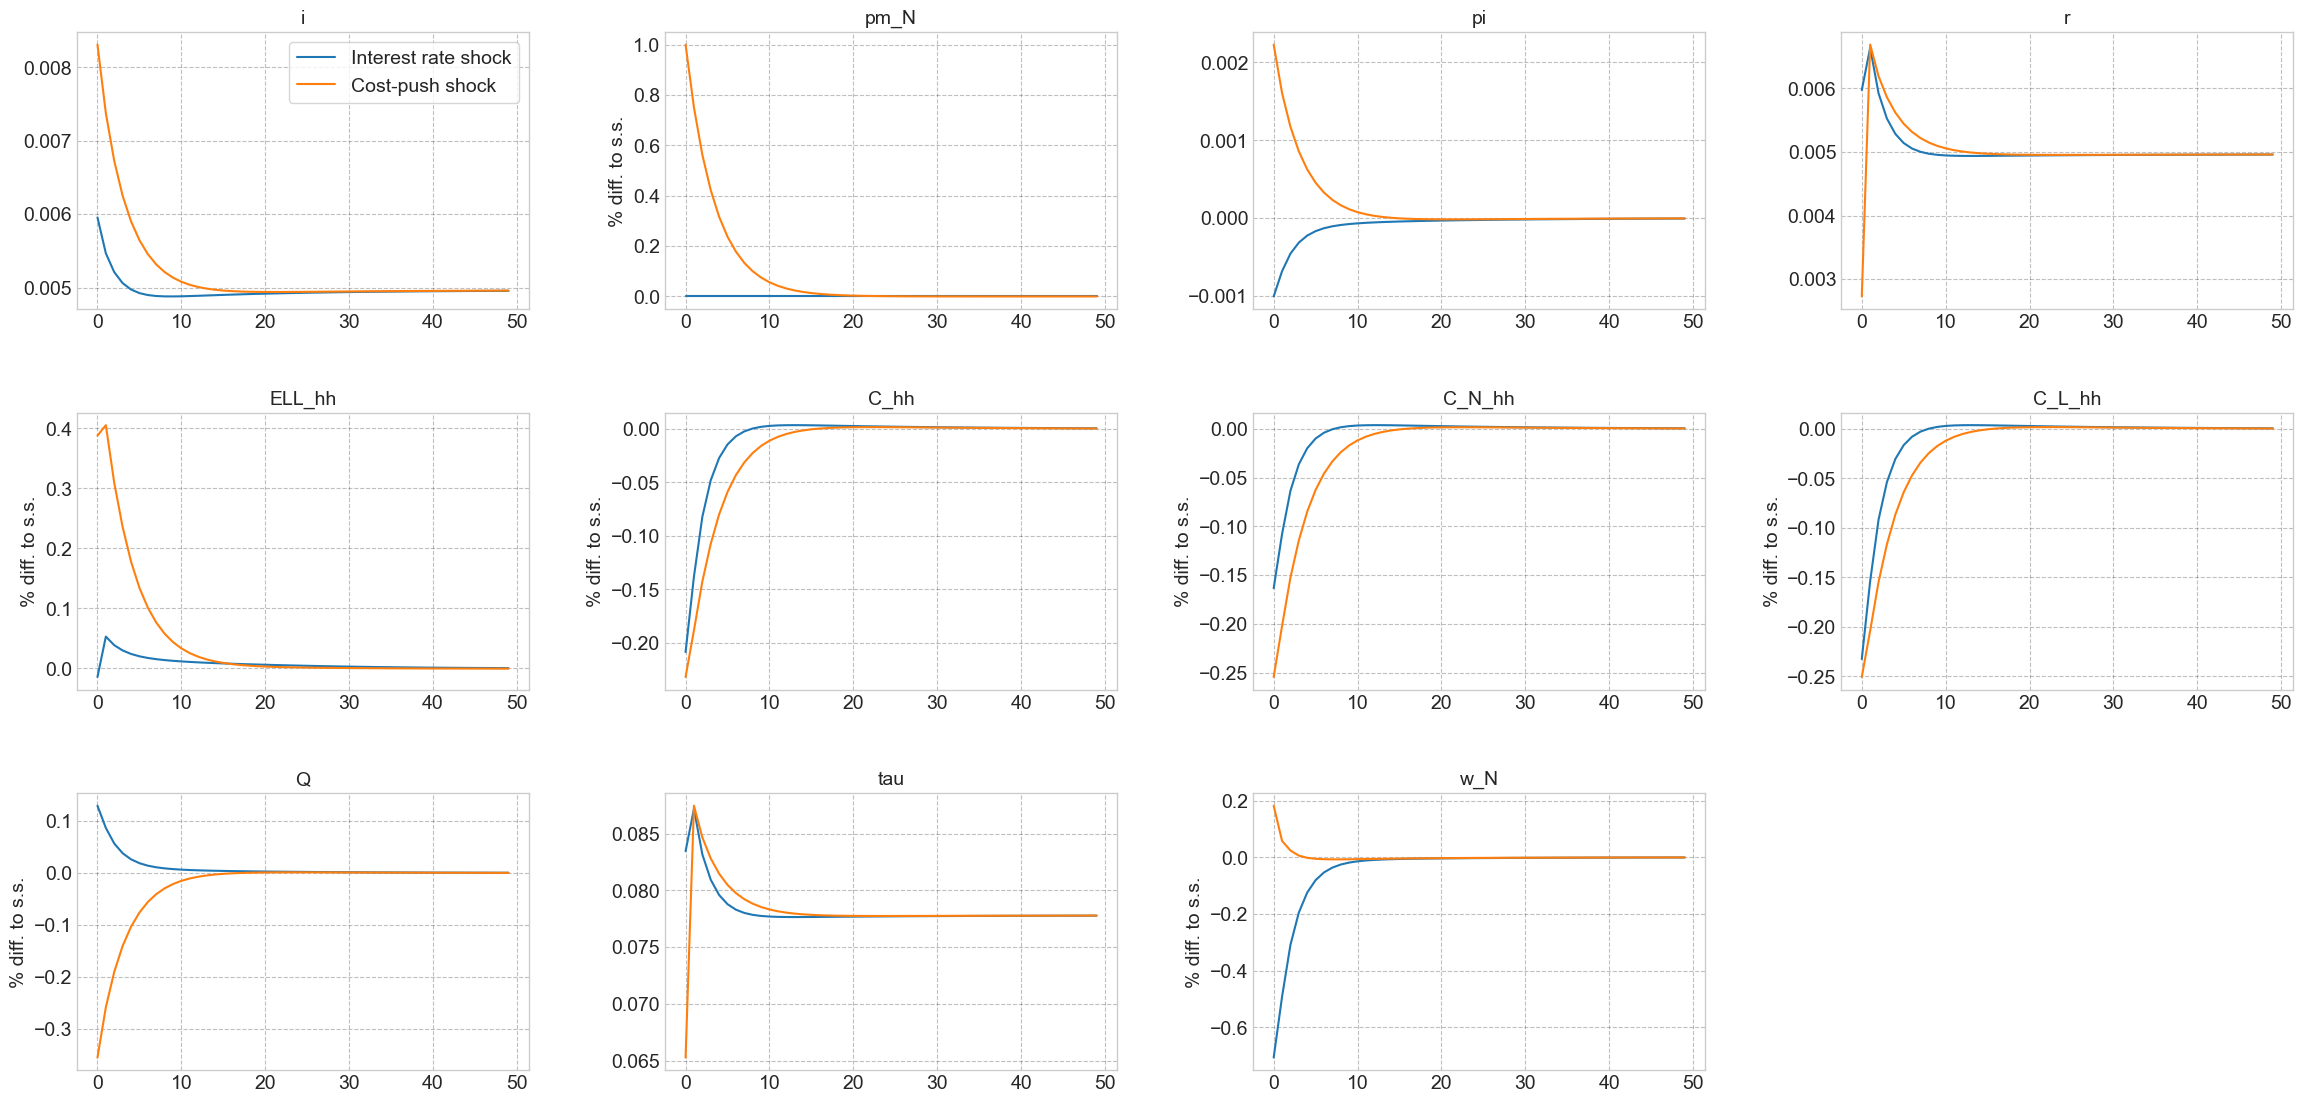

In [5]:
# Household stuff
model.compare_IRFs([model,model_push],['Interest rate shock','Cost-push shock'],paths_hh,abs_diff=hh_names,lvl_value=lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=4)

### varnames ###


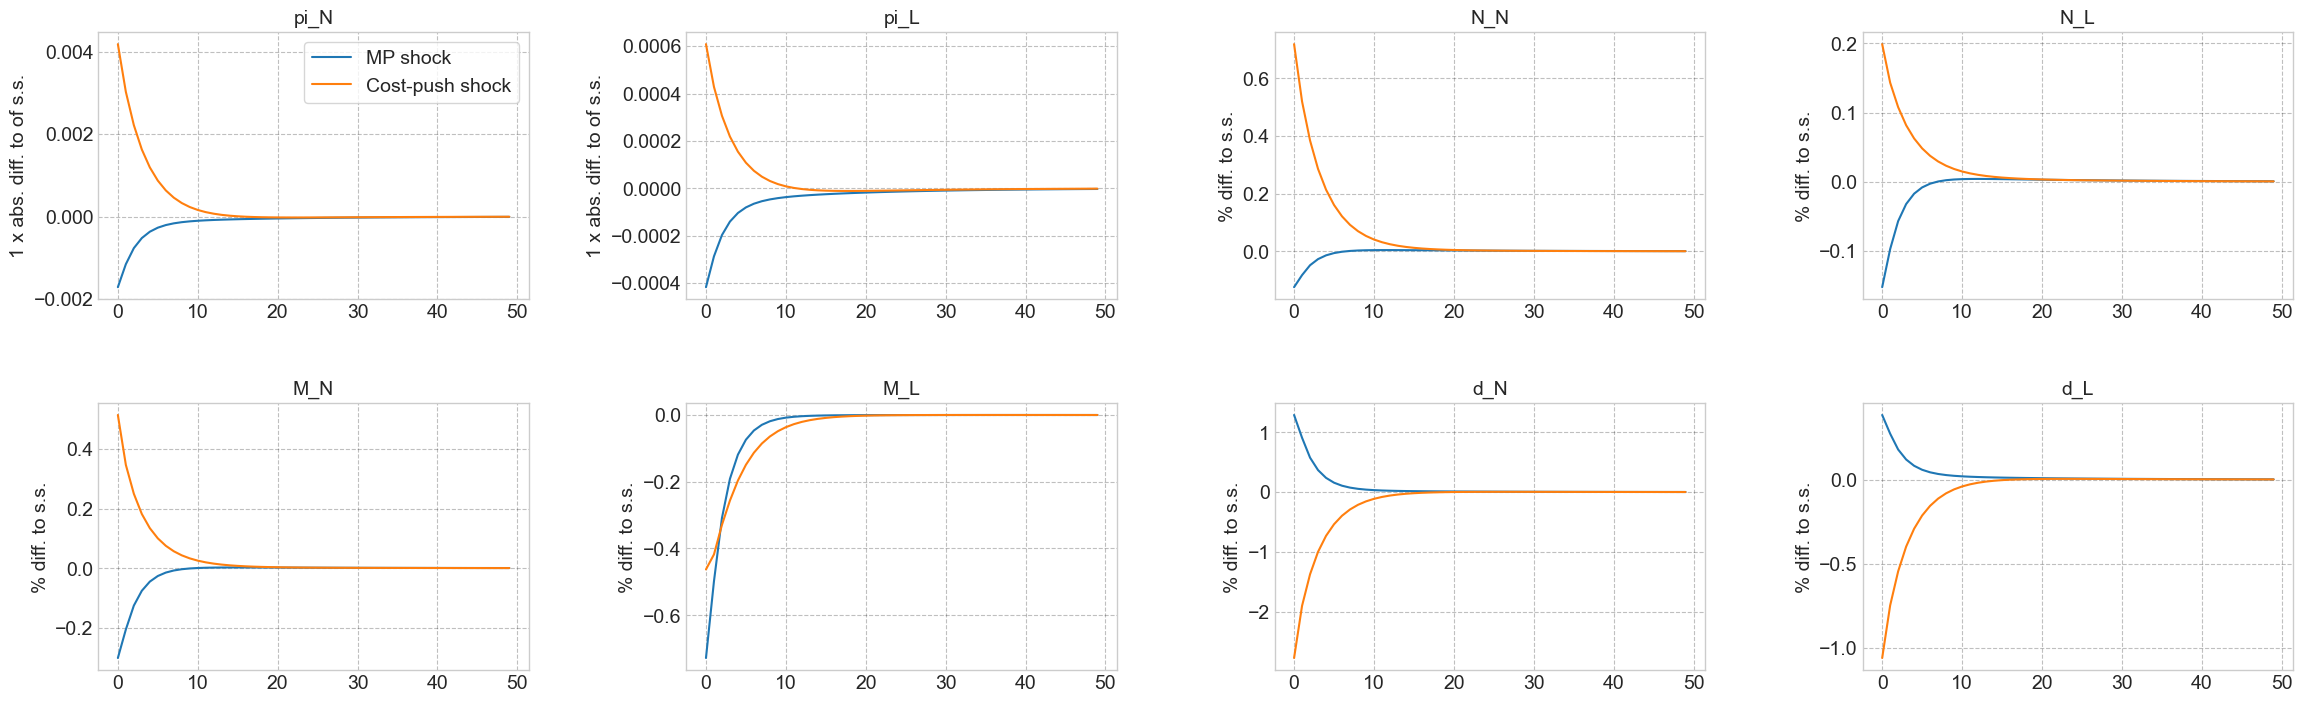

In [6]:
# Firm stuff
model.compare_IRFs([model,model_push],['MP shock','Cost-push shock'],paths_firms,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=4)

### Household stuff, pretty

In [7]:
'''
paths_hh = ['i','pm_N','pi','r','ELL_hh','C_hh','C_N_hh','C_L_hh','Q','tau','w_N']
hh_names = ['Nominal Interest Rate','Inflation','Real Interest Rate','Relative Price','Labor Supply','Consumption','Necessity Consumption','Luxury Consumption','Tax Rate','Wage, N']
paths_firms =['pi_N','pi_L','N_N','N_L','M_N','M_L','d_N','d_L']
firms_names = ['Inflation, N','Inflation, L','Labor, N','Labor, L','Materials, N','Materials, L','Dividends, N','Dividends, L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push
'''
T_max = 50 

fig = plt.figure(figsize=(5*4,3*4),dpi=750)

# First row = absolute difference to steady state in percent
ax = fig.add_subplot(3,4,1)
ax.set_title('Nominal Interest Rate*')
ax.plot((model.path.i[0,:T_max]-ss.i)*100,label=f'Interest Rate Shock')
ax.plot((model_push.path.i[0,:T_max]-ss.i)*100,label=f'Cost-Push Shock')
ax.legend(frameon=True,prop={'size': 15})

ax = fig.add_subplot(3,4,2)
ax.set_title('Price: Raw Materials')
ax.plot((model.path.pm_N[0,:T_max]-ss.pm_N)/model.ss.Q*100,label=f'Interest Rate Shock')
ax.plot((model_push.path.pm_N[0,:T_max]-model_push.ss.pm_N)/model_push.ss.Q*100,label=f'Cost-Push Shock')

ax = fig.add_subplot(3,4,3)
ax.set_title('Inflation: Aggregate*')
ax.plot((model.path.pi[0,:T_max]-ss.pi)*100,label=f'Two-sector')
ax.plot((model_push.path.pi[0,:T_max]-ss.pi)*100,label=f'One-sector')

ax = fig.add_subplot(3,4,4)
ax.set_title('Real Interest Rate*')
ax.plot((model.path.r[0,:T_max]-ss.r)*100,label=f'Two-sector')
ax.plot((model_push.path.r[0,:T_max]-ss.r)*100,label=f'One-sector')

# Second row = percentage difference to steady state
ax = fig.add_subplot(3,4,5)
ax.set_title('Labor Supply')
ax.plot((model.path.ELL_hh[0,:T_max]-ss.ELL_hh)/ss.ELL_hh*100,label=f'Two-sector')
ax.plot((model_push.path.ELL_hh[0,:T_max]-model_push.ss.ELL_hh)/model_push.ss.ELL_hh*100,label=f'Two-sector')

ax = fig.add_subplot(3,4,6)
ax.set_title('Consumption: Total')
ax.plot((model.path.C_hh[0,:T_max]-ss.C_hh)/ss.C_hh*100,label=f'Two-sector')
ax.plot((model_push.path.C_hh[0,:T_max]-model_push.ss.C_hh)/model_push.ss.C_hh*100,label=f'Two-sector')

ax = fig.add_subplot(3,4,7)
ax.set_title('Consumption: Necessities')
ax.plot((model.path.C_N_hh[0,:T_max]-ss.C_N_hh)/ss.C_N_hh*100,label=f'Two-sector')
ax.plot((model_push.path.C_N_hh[0,:T_max]-model_push.ss.C_N_hh)/model_push.ss.C_N_hh*100,label=f'Two-sector')

ax = fig.add_subplot(3,4,8)
ax.set_title('Consumption: Luxuries')
ax.plot((model.path.C_L_hh[0,:T_max]-ss.C_L_hh)/ss.C_L_hh*100,label=f'Two-sector')
ax.plot((model_push.path.C_L_hh[0,:T_max]-model_push.ss.C_L_hh)/model_push.ss.C_L_hh*100,label=f'Two-sector')

# Third row = pct. difference to SS
ax = fig.add_subplot(3,4,9)
ax.set_title('Relative Price of Luxuries, Q')
ax.plot((model.path.Q[0,:T_max]-ss.Q)/ss.Q*100,label=f'Two-sector')
ax.plot((model_push.path.Q[0,:T_max]-model_push.ss.Q)/model_push.ss.Q*100,label=f'Two-sector')

ax = fig.add_subplot(3,4,10)
ax.set_title('Tax Rate*')
ax.plot((model.path.tau[0,:T_max]-ss.tau)*100,label=f'Two-sector')
ax.plot((model_push.path.tau[0,:T_max]-model_push.ss.tau)*100,label=f'Two-sector')

ax = fig.add_subplot(3,4,11)
ax.set_title('Real Wage')
ax.plot((model.path.w_N[0,:T_max]-ss.w_N)/ss.w_N*100,label=f'Two-sector')
ax.plot((model_push.path.w_N[0,:T_max]-model_push.ss.w_N)/ss.w_N*100,label=f'Two-sector')


### Firm stuff, pretty

In [8]:
T_max = 50 

fig = plt.figure(figsize=(5*4,2*4),dpi=750)

# First row = absolute difference to steady state in percent
ax = fig.add_subplot(2,4,1)
ax.set_title('Inflation*',fontsize=18)
ax.plot((model.path.pi_N[0,:T_max]-ss.pi_N)*100,label=f'Interest Rate Shock')
ax.plot((model_push.path.pi_N[0,:T_max]-ss.pi_N)*100,label=f'Cost-Push Shock')
ax.legend(frameon=True,prop={'size': 15})
ax.set_ylabel('Sector: Necessities',fontsize=18)

ax = fig.add_subplot(2,4,2)
ax.set_title('Raw Materials',fontsize=18)
ax.plot((model.path.M_N[0,:T_max]-ss.M_N)/ss.M_N*100,label=f'Two-sector')
ax.plot((model_push.path.M_N[0,:T_max]-model_push.ss.M_N)/model_push.ss.M_N*100,label=f'Two-sector')


ax = fig.add_subplot(2,4,3)
ax.set_title('Effective Labor',fontsize=18)
ax.plot((model.path.N_N[0,:T_max]-ss.N_N)/model.ss.N_N*100,label=f'Interest Rate Shock')
ax.plot((model_push.path.N_N[0,:T_max]-model_push.ss.N_N)/model_push.ss.N_N*100,label=f'Cost-Push Shock')


ax = fig.add_subplot(2,4,4)
ax.set_title('Dividends',fontsize=18)
ax.plot((model.path.d_N[0,:T_max]-ss.d_N)/ss.d_N*100,label=f'Two-sector')
ax.plot((model_push.path.d_N[0,:T_max]-model_push.ss.d_N)/model_push.ss.d_N*100,label=f'Two-sector')

# Sector L:
ax = fig.add_subplot(2,4,5)
#ax.set_title('Inflation: Sector L*')
ax.plot((model.path.pi_L[0,:T_max]-ss.pi_L)*100,label=f'Interest Rate Shock')
ax.plot((model_push.path.pi_L[0,:T_max]-ss.pi_L)*100,label=f'Cost-Push Shock')
ax.set_ylabel('Sector: Luxuries',fontsize=18)


ax = fig.add_subplot(2,4,6)
#ax.set_title('Raw Materials: Sector L')
ax.plot((model.path.M_L[0,:T_max]-ss.M_L)/ss.M_L*100,label=f'Two-sector')
ax.plot((model_push.path.M_L[0,:T_max]-model_push.ss.M_L)/model_push.ss.M_L*100,label=f'Two-sector')

ax = fig.add_subplot(2,4,7)
#ax.set_title('Effective Labor: Sector L')
ax.plot((model.path.N_L[0,:T_max]-ss.N_L)/model.ss.N_L*100,label=f'Interest Rate Shock')
ax.plot((model_push.path.N_L[0,:T_max]-model_push.ss.N_L)/model_push.ss.N_L*100,label=f'Cost-Push Shock')

ax = fig.add_subplot(2,4,8)
#ax.set_title('Dividends: Sector L')
ax.plot((model.path.d_L[0,:T_max]-ss.d_L)/ss.d_L*100,label=f'Two-sector')
ax.plot((model_push.path.d_L[0,:T_max]-model_push.ss.d_L)/model_push.ss.d_L*100,label=f'Two-sector')


# Decomposition by wealth: Monetary Policy Shock

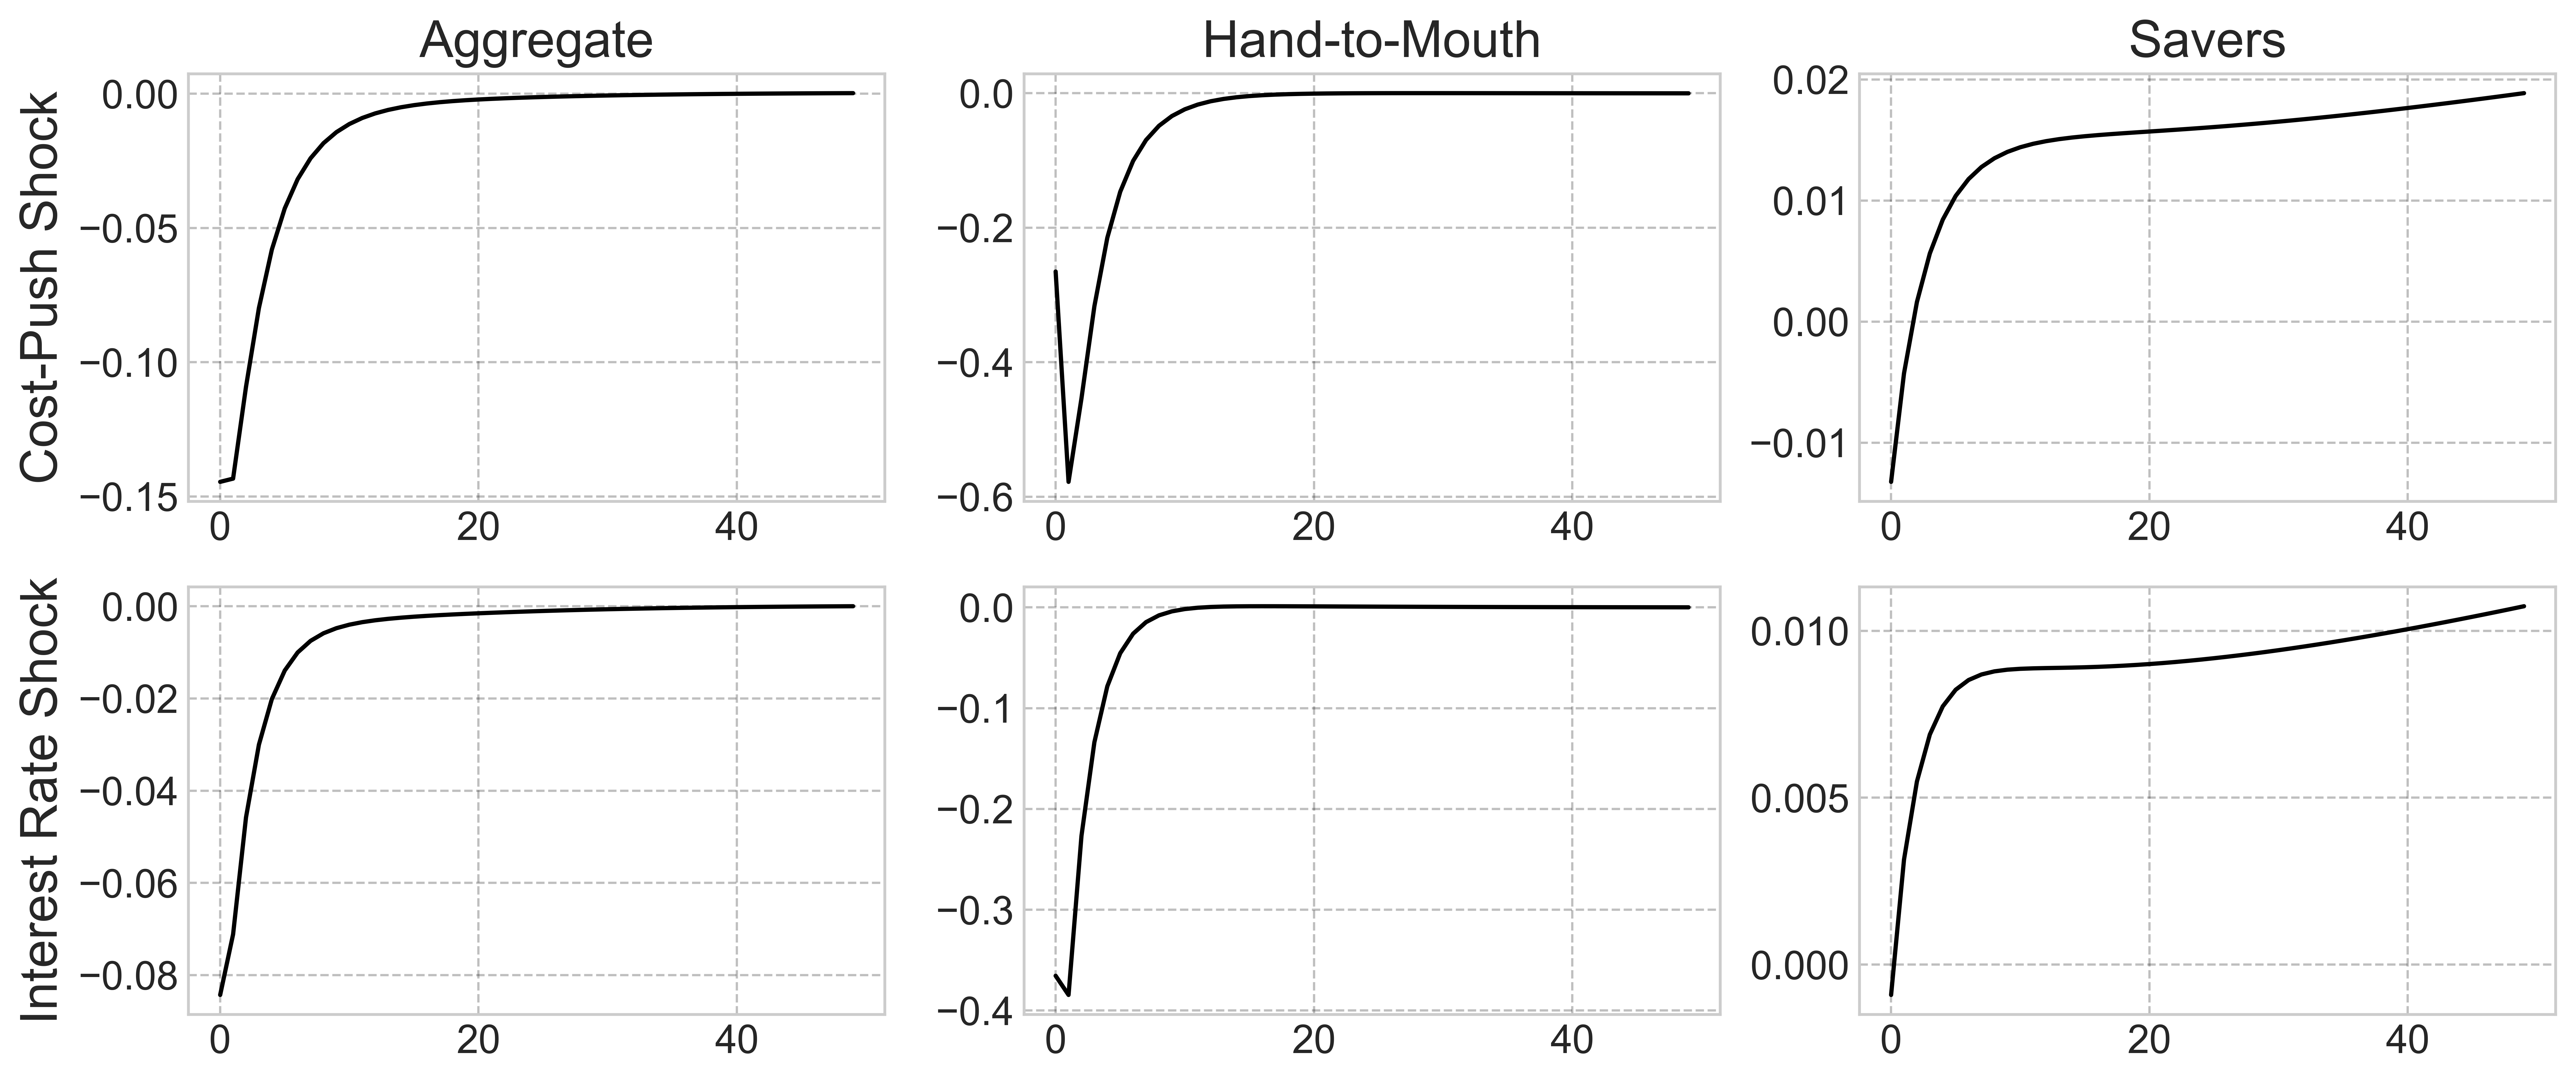

In [21]:
#par.jump_istar = 0.0025 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
Dbeg = ss.Dbeg.copy()
model.find_transition_path(do_print=False) #all
### Plot stuff ### 
fig = plt.figure(figsize=(5*3,2*3),dpi=750)
#fig.suptitle('Figure title')

### AGGREGATE ###
ax = fig.add_subplot(2,3,1)
i_color = 0
# a. compute
Dbeg = ss.Dbeg.copy()
path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt.E_hh[0,:T_max]-path_alt_ss.E_hh[0,:T_max])/path_alt_ss.E_hh[0,:T_max]*100, 'k')
ax.set_title('Aggregate',fontsize=18)    
ax.set_ylabel('Cost-Push Shock',fontsize=18)

### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize
ax = fig.add_subplot(2,3,2)
# a. compute
path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt.E_hh[0,:T_max]-path_alt_ss.E_hh[0,:T_max])/path_alt_ss.E_hh[0,:T_max]*100, 'k')
ax.set_title('Hand-to-Mouth',fontsize=18)    

### RICHEST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize
ax = fig.add_subplot(2,3,3)
# a. compute
path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt.E_hh[0,:T_max]-path_alt_ss.E_hh[0,:T_max])/path_alt_ss.E_hh[0,:T_max]*100, 'k')
ax.set_title('Savers',fontsize=18)    
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Savers', fontsize=18)
#ax.legend(frameon=True);
Dbeg = ss.Dbeg.copy()


par.jump_istar = 0.0025 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

### AGGREGATE ###
ax = fig.add_subplot(2,3,4)
i_color = 0
# a. compute
Dbeg = ss.Dbeg.copy()
path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt.E_hh[0,:T_max]-path_alt_ss.E_hh[0,:T_max])/path_alt_ss.E_hh[0,:T_max]*100, 'k')
ax.set_ylabel('Interest Rate Shock',fontsize=18)

### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize
ax = fig.add_subplot(2,3,5)
# a. compute
path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt.E_hh[0,:T_max]-path_alt_ss.E_hh[0,:T_max])/path_alt_ss.E_hh[0,:T_max]*100, 'k')

### RICHEST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize
ax = fig.add_subplot(2,3,6)
# a. compute
path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt.E_hh[0,:T_max]-path_alt_ss.E_hh[0,:T_max])/path_alt_ss.E_hh[0,:T_max]*100, 'k')
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Savers', fontsize=18)
#ax.legend(frameon=True);
Dbeg = ss.Dbeg.copy()




### Main decomposition for direct, income, and price effects

In [ ]:
par.jump_istar = 0.0025 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

### Plot stuff ### 
fig = plt.figure(figsize=(5*4,3*4),dpi=750)
#fig.suptitle('Figure title')

### AGGREGATE ###
ax = fig.add_subplot(3,4,2)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Necessity Consumption',fontsize=18)    
#ax.set_ylabel('Aggregate', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Luxury Consumption',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Labor supply',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'No inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'All inputs'
        ls = '-'
        color = 'black'
    else:
        label = use_inputs[0]
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]/ss.P_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Individual Price Index',fontsize=18)        
ax.set_ylabel('Aggregate',fontsize=18)
ax.legend(frameon=True,prop={'size': 15})


### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,6)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Hand-to-Mouth', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,7)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,8)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,5)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Hand-to-Mouth',fontsize=18)
#ax.legend(frameon=True)


### RICHEST ###

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,10)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Savers', fontsize=18)
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,11)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,12)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,9)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Savers',fontsize=18)
#ax.legend(frameon=True)



### Appendix: Decomposition by direct, price, wage, dividends, taxes

In [ ]:
par.jump_istar = 0.0025 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

### Plot stuff ### 
fig = plt.figure(figsize=(5*4,3*4),dpi=750)
#fig.suptitle('Figure title')

inputs = [['Direct effects','r'],['Q'],['p_N'],['p_L'],['P'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']

### AGGREGATE ###
ax = fig.add_subplot(3,4,2)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Necessity Consumption',fontsize=18)    
#ax.set_ylabel('Aggregate', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,3)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Luxury Consumption',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,4)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Labor supply',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,1)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'No inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'All inputs'
        ls = '-'
        color = 'black'
    else:
        label = use_inputs[0]
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]/ss.P_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Individual Price Index',fontsize=18)        
ax.set_ylabel('Aggregate',fontsize=18)
ax.legend(frameon=True,prop={'size': 15})


### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,6)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Hand-to-Mouth', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,7)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,8)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,5)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Hand-to-Mouth',fontsize=18)
#ax.legend(frameon=True)


### RICHEST ###

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,10)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Savers', fontsize=18)
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,11)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,12)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,9)
i_color = 0
for use_inputs in inputs:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Savers',fontsize=18)
#ax.legend(frameon=True)



# Decomposition by wealth - Cost-Push Shock

### Main: Decomposed CP shock by direct, income and price effects

In [ ]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

### Plot stuff ### 
fig = plt.figure(figsize=(5*4,3*4),dpi=750)
#fig.suptitle('Figure title')

### AGGREGATE ###
ax = fig.add_subplot(3,4,2)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Necessity Consumption',fontsize=18)    
#ax.set_ylabel('Aggregate', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Luxury Consumption',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Labor supply',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'No inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'All inputs'
        ls = '-'
        color = 'black'
    else:
        label = use_inputs[0]
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]/ss.P_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Individual Price Index',fontsize=18)        
ax.set_ylabel('Aggregate',fontsize=18)
ax.legend(frameon=True,prop={'size': 15})

### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,6)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Hand-to-Mouth', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,7)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,8)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,5)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Hand-to-Mouth',fontsize=18)
#ax.legend(frameon=True)


### RICHEST ###

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,10)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Savers', fontsize=18)
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,11)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,12)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,9)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Savers',fontsize=18)
#ax.legend(frameon=True)


### Appendix: Decomposed CP shock by direct, price, wages, taxes, dividends

In [ ]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all


### Plot stuff ### 
fig = plt.figure(figsize=(5*4,3*4),dpi=750)
#fig.suptitle('Figure title')

### AGGREGATE ###
ax = fig.add_subplot(3,4,2)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Necessity Consumption',fontsize=18)    
#ax.set_ylabel('Aggregate', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,3)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Luxury Consumption',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,4)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Labor supply',fontsize=18)        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'No inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'All inputs'
        ls = '-'
        color = 'black'
    else:
        label = use_inputs[0]
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]/ss.P_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Individual Price Index',fontsize=18)        
ax.set_ylabel('Aggregate',fontsize=18)
ax.legend(frameon=True,prop={'size': 15})


### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,6)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Hand-to-Mouth', fontsize=18)
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,7)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,8)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,5)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Hand-to-Mouth',fontsize=18)
#ax.legend(frameon=True)


### RICHEST ###

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,10)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Necessity Consumption')    
#ax.set_ylabel('Savers', fontsize=18)
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,11)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Luxury Consumption')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,12)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True)

ax = fig.add_subplot(3,4,9)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Taxes','tau'],['Wages','w_N','w_L'],['Dividends','d_N','d_L'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label)
#ax.set_title('Individual Price Index')        
ax.set_ylabel('Savers',fontsize=18)
#ax.legend(frameon=True)

# 3-D GRAPHS YESSSS

In [ ]:
'''
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass
from HANKmodel_baseline import HANKModelClass_baseline
'''

In [ ]:
model = HANKModelClass(name='two_sector')

par = model.par
ss = model.ss
path = model.path
sim = model.sim

T_max = 50

path_alt_list = []
path_alt_ss_list = []

#model.par.alpha_N = 0.5
#model.par.alpha_L = 0.5
#model.par.mu_L = 1.5
#model.par.mu_N = 1.5
#model.par.kappa_L = 0.125
#model.par.kappa_N = 0.125
#model.par.gamma_L = 0.5
#model.par.gamma_N = 0.5
model.find_ss()
model.compute_jacs()
T_max = 50
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
par.jump_istar     = 0.00    # MP shock
#par.jump_istar     = 0.0025 # MP shock
model.find_transition_path(do_print=False) #all

#or i in range(10):
#
#   Dbeg = ss.Dbeg.copy()
#   Dbeg = np.sum(Dbeg[0],axis=0) # sum over z --> return a 1d array (500,)
#   #Dbeg = Dbeg.to_list()
#   f = np.percentile(Dbeg,i+1) # returns value at the ith percentile
#   Dbeg.index(f)
#
#   #np.cumsum(np.sum(Dbeg[0],axis=0))
#   #Dbeg[:,i+1:,:] = 0.0 # zero every else than in first asset grid point
#   #Dbeg[:,:i,:] = 0.0 # zero every else than in first asset grid point
#   #Dbeg /= np.sum(Dbeg) # re-normalize
#
#   path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
#   path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
#
#   path_alt_list.append(path_alt)
#   path_alt_ss_list.append(path_alt_ss)
#
#


In [ ]:
for i in range(7):

    Dbeg = ss.Dbeg.copy()
    Dbeg[:,i+1:,:] = 0.0 # zero every else than in first asset grid point
    Dbeg[:,:i,:] = 0.0 # zero every else than in first asset grid point
    Dbeg /= np.sum(Dbeg) # re-normalize

    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

    path_alt_list.append(path_alt)
    path_alt_ss_list.append(path_alt_ss)



T_max = 25

data_C_hh = np.empty((par.Nz,T_max))
data_C_N_hh = np.empty((par.Nz,T_max))
data_C_L_hh = np.empty((par.Nz,T_max))
data_ELL_hh = np.empty((par.Nz,T_max))
data_P_hh = np.empty((par.Nz,T_max))
data_U_hh = np.empty((par.Nz,T_max))
data_A_hh = np.empty((par.Nz,T_max))

for i in range(7):
    data_C_hh[i,:] = (path_alt_list[i].C_hh[0,:T_max]-path_alt_ss_list[i].C_hh[0,:T_max])/path_alt_ss_list[i].C_hh[0,:T_max]*100
    data_C_N_hh[i,:] = (path_alt_list[i].C_N_hh[0,:T_max]-path_alt_ss_list[i].C_N_hh[0,:T_max])/path_alt_ss_list[i].C_N_hh[0,:T_max]*100
    data_C_L_hh[i,:] = (path_alt_list[i].C_L_hh[0,:T_max]-path_alt_ss_list[i].C_L_hh[0,:T_max])/path_alt_ss_list[i].C_L_hh[0,:T_max]*100
    data_ELL_hh[i,:] = (path_alt_list[i].ELL_hh[0,:T_max]-path_alt_ss_list[i].ELL_hh[0,:T_max])/path_alt_ss_list[i].ELL_hh[0,:T_max]*100
    data_P_hh[i,:] = (path_alt_list[i].P_hh[0,:T_max]-path_alt_ss_list[i].P_hh[0,:T_max])/path_alt_ss_list[i].P_hh[0,:T_max]*100
    data_U_hh[i,:] = (path_alt_list[i].U_hh[0,:T_max]-path_alt_ss_list[i].U_hh[0,:T_max])/path_alt_ss_list[i].U_hh[0,:T_max]*-100
    data_A_hh[i,:] = (path_alt_list[i].A_hh[0,:T_max]-path_alt_ss_list[i].A_hh[0,:T_max])/path_alt_ss_list[i].A_hh[0,:T_max]*100


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['legend.fontsize'] = 10


fig = plt.figure(figsize=(12,8),dpi=100)


#Consumption
length = data_C_hh.shape[1]
width = data_C_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,1, projection='3d')
surf = ax.plot_surface(x, y, data_C_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Consumption: Total')        
#ax.set_zlabel('% Diff to s.s.')
#ax.set_ylabel('Income type')
#ax.set_xlabel('')

#Consumption necessities
length = data_C_N_hh.shape[1]
width = data_C_N_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,2, projection='3d')
surf = ax.plot_surface(x, y, data_C_N_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
ax.set_title('Consumption: Necessities')        

#Consumption luxuries
length = data_C_L_hh.shape[1]
width = data_C_L_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,3, projection='3d')
surf = ax.plot_surface(x, y, data_C_L_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
ax.set_title('Consumption: Luxuries')        

#Labor
length = data_ELL_hh.shape[1]
width = data_ELL_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,4, projection='3d')
surf = ax.plot_surface(x, y, data_ELL_hh,cmap=cm.coolwarm)
ax.view_init(30, 250)
ax.set_title('Labor Supply')        

#IPI
length = data_P_hh.shape[1]
width = data_P_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,5, projection='3d')
surf = ax.plot_surface(x, y, data_P_hh,cmap=cm.coolwarm)
ax.view_init(30, 250)
ax.set_title('Individual Price Index')        


#Utility
length = data_U_hh.shape[1]
width = data_U_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,6, projection='3d')
surf = ax.plot_surface(x, y, data_U_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
ax.set_title('Utility')        

plt.show()


## Monetary Policy experiements

Nondecomposed behavior for a subset of households. Here consumption for those with zero assets contra max assets.

In [ ]:
T_max = 50

path_alt_poor_list = []
path_alt_poor_ss_list = []

path_alt_rich_list = []
path_alt_rich_ss_list = []

path_alt_avg_list = []
path_alt_avg_ss_list = []

#for i in range(5):
for i in range(5):
        #mod = model.copy()
        ss = model.ss
        par = model.par
        par.phi = 1+i/4
        #model.par.alpha_N = 0.46
        #model.par.alpha_L = 0.46
        #model.par.mu_L = 1.5
        #model.par.mu_N = 1.5
        #model.par.kappa_L = 0.125
        #model.par.kappa_N = 0.125
        #model.par.gamma_L = 0.5
        #model.par.gamma_N = 0.5
        model.find_ss()
        model.par.jump_istar = 0.0 # no Monetary policy shock
        par.jump_pm_N     = 0.01*ss.Q # cost push shock
        model.compute_jacs()
        model.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_poor_list.append(path_alt_poor)
        path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:475] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_rich_list.append(path_alt_rich)
        path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_avg_list.append(path_alt_average)
        path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []


In [ ]:
#path_alt_poor_list[0].C_hh[0,:T_max]

T_max = 20
vec_poor_p = []
vec_rich_p = []
vec_avg_p = []

columns = ['1.0','1.25','1.5','1.75','2.0']
rows = ['Hand-to-mouth','Aggregate','Savers']

for i,(a,b,c,d,e,f) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,path_alt_rich_list,path_alt_rich_ss_list,path_alt_avg_list,path_alt_avg_ss_list)):
    
    vec_poor_p.append(np.mean(((a.P_hh[0,:T_max]-b.P_hh[0,:T_max])/b.P_hh[0,:T_max])/((path_alt_poor_list[2].P_hh[0,:T_max]-path_alt_poor_ss_list[2].P_hh[0,:T_max])/path_alt_poor_ss_list[2].P_hh[0,:T_max])-1))
    vec_rich_p.append(np.mean(((c.P_hh[0,:T_max]-d.P_hh[0,:T_max])/d.P_hh[0,:T_max])/((path_alt_rich_list[2].P_hh[0,:T_max]-path_alt_rich_ss_list[2].P_hh[0,:T_max])/path_alt_rich_ss_list[2].P_hh[0,:T_max])-1))
    vec_avg_p.append(np.mean(((e.P_hh[0,:T_max]-f.P_hh[0,:T_max])/f.P_hh[0,:T_max])/((path_alt_avg_list[2].P_hh[0,:T_max]-path_alt_avg_ss_list[2].P_hh[0,:T_max])/path_alt_avg_ss_list[2].P_hh[0,:T_max])-1))
    vecs = [vec_poor_p,vec_avg_p,vec_rich_p]
#path_alt_poor_list[0-5].[P,U,C,CN,CL,ELL]
df_paths = pd.DataFrame(data=vecs,columns=columns,index=rows).round(decimals=2)
print(df_paths.to_latex())


Show IRFs

In [ ]:
fig = plt.figure(figsize=(3*6,3*4),dpi=300)

ax = fig.add_subplot(3,3,1)
ax.set_title('Nominal interest rate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.i[0,:50]-b.i[0,:50])*100,label=f'phi ={1+i/4} ')
#ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

ax = fig.add_subplot(3,3,2)
ax.set_title('Aggregate IPI')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,3)
ax.set_title('Real Interest rate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.r[0,:50]-b.r[0,:50])*100)

ax = fig.add_subplot(3,3,4)
ax.set_title('Price: Necessity goods')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.p_N[0,:50]-b.p_N[0,:50])/b.p_N[0,:50]*100)
#ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,5)
ax.set_title('Price: Luxury goods')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.p_L[0,:50]-b.p_L[0,:50])/b.p_L[0,:50]*100)

ax = fig.add_subplot(3,3,6)
ax.set_title('Relative prices, Q')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.Q[0,:50]-b.Q[0,:50])/b.Q[0,:50]*100)

ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Necessities')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_N_hh[0,:50]-b.C_N_hh[0,:50])/b.C_N_hh[0,:50]*100)
#ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,8)
ax.set_title('Consumption: Luxuries')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_L_hh[0,:50]-b.C_L_hh[0,:50])/b.C_L_hh[0,:50]*100)

ax = fig.add_subplot(3,3,9)
ax.set_title('Labor supply')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)


Plots of consumption decompositions by wealth levels:

In [ ]:
fig = plt.figure(figsize=(3*6,5*4),dpi=300)

#Consumption
ax = fig.add_subplot(5,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(5,3,2)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(5,3,3)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

#labor supply
ax = fig.add_subplot(5,3,4)
ax.set_title('Labor Supply: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(5,3,5)
ax.set_title('Labor Supply: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(5,3,6)
ax.set_title('Labor Supply: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)


#utility
ax = fig.add_subplot(5,3,7)
ax.set_title('Utility: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(5,3,8)
ax.set_title('Utility: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(5,3,9)
ax.set_title('Utility: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

#IPI
ax = fig.add_subplot(5,3,10)
ax.set_title('Individual price index: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(5,3,11)
ax.set_title('Individual price index: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(5,3,12)
ax.set_title('Individual price index: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

"""
#IPI
ax = fig.add_subplot(5,3,13)
ax.set_title('Individual price index: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot(((a.P_hh[0,:25]-b.P_hh[0,:25])/b.P_hh[0,:25])/((path_alt_poor_list[2].P_hh[0,:25]-path_alt_poor_ss_list[2].P_hh[0,:25])/path_alt_poor_ss_list[2].P_hh[0,:25]))

ax = fig.add_subplot(5,3,14)
ax.set_title('Individual price index: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot(((a.P_hh[0,:25]-b.P_hh[0,:25])/b.P_hh[0,:25])/((path_alt_rich_list[2].P_hh[0,:25]-path_alt_rich_ss_list[2].P_hh[0,:25])/path_alt_rich_ss_list[2].P_hh[0,:25]))

ax = fig.add_subplot(5,3,15)
ax.set_title('Individual price index: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot(((a.P_hh[0,:25]-b.P_hh[0,:25])/b.P_hh[0,:25])/((path_alt_avg_list[2].P_hh[0,:25]-path_alt_avg_ss_list[2].P_hh[0,:25])/path_alt_avg_ss_list[2].P_hh[0,:25]))
"""

## Find effect of parameter change

In [ ]:
T_max = 50

path_alt_poor_list = []
path_alt_poor_ss_list = []

path_alt_rich_list = []
path_alt_rich_ss_list = []

path_alt_avg_list = []
path_alt_avg_ss_list = []

### Fiks det her ####
alphas_N = [0.63, 0.45   , 0.63  , 0.63  , 0.63]
alphas_L = [0.31, 0.45   , 0.31  , 0.31  , 0.31]
mus_N    = [1.2, 1.2   , 1.5   , 1.2   , 1.2 ]
mus_L    = [1.8, 1.8   , 1.5   , 1.8   , 1.8 ]
kappas_N = [0.22, 0.22  , 0.22  , 0.125 , 0.22]
kappas_L = [0.04, 0.04  , 0.04  , 0.125 , 0.04]
gammas_N = [0.25, 0.25  , 0.25  , 0.25  , 0.5 ]
gammas_L = [0.815, 0.815 , 0.815 , 0.815 , 0.5 ]

        
for i in range(5):
        #mod = model.copy()
        ss = model.ss
        par = model.par
        par.phi = 1.5
        model.par.alpha_N  = alphas_N[i]
        model.par.alpha_L  = alphas_L[i]
        model.par.mu_L     = mus_L[i]
        model.par.mu_N     = mus_N[i]
        model.par.kappa_L  = kappas_L[i]
        model.par.kappa_N  = kappas_N[i]
        model.par.gamma_L  = gammas_L[i]
        model.par.gamma_N  = gammas_N[i]
        model.find_ss()
        #model.par.jump_istar = 0.0025 # 25 BP Monetary policy shock
        model.par.jump_pm_N     = 0.01*model.ss.Q # cost push shock
        model.compute_jacs()
        model.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_poor_list.append(path_alt_poor)
        path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:475] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_rich_list.append(path_alt_rich)
        path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_avg_list.append(path_alt_average)
        path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []

#path_alt_poor_list[0].C_hh[0,:T_max]

#model.par.alpha_N  = alphas_N[0]
#model.par.alpha_L  = alphas_L[0]
#model.par.mu_L     = mus_L[0]
#model.par.mu_N     = mus_N[0]
#model.par.kappa_L  = kappas_L[0]
#model.par.kappa_N  = kappas_N[0]
#model.par.gamma_L  = gammas_L[0]
#model.par.gamma_N  = gammas_N[0]


#### Plots of consumption decompositions by wealth levels:

In [ ]:
sensitivity_names = ['No sectoral difference','alpha_$s$ = 0.5','mu_$s$ = 1.5','kappa_$s$ = 0.125','gamma_$s$ = 0.5']

fig = plt.figure(figsize=(5*4,3*4),dpi=100)

#poor 
ax = fig.add_subplot(3,4,1)
ax.set_title('Individual Price Index')
for i,(a,b,c) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list,sensitivity_names)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100,label=c)
ax.set_ylabel('Aggregate',fontsize=18)
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,4,2)
ax.set_title('Consumption: Necessities')
for i,(a,b,c) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list,sensitivity_names)):
    ax.plot((a.C_N_hh[0,:50]-b.C_N_hh[0,:50])/b.C_N_hh[0,:50]*100,label=c)

ax = fig.add_subplot(3,4,3)
ax.set_title('Consumption: Luxuries')
for i,(a,b,c) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list,sensitivity_names)):
    ax.plot((a.C_L_hh[0,:50]-b.C_L_hh[0,:50])/b.C_L_hh[0,:50]*100,label=c)


ax = fig.add_subplot(3,4,4)
ax.set_title('Labor Supply')
for i,(a,b,c) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list,sensitivity_names)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100,label=c)


ax = fig.add_subplot(3,4,5)
#ax.set_title('Individual Price Index')
for i,(a,b,c) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,sensitivity_names)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100,label=c)
ax.set_ylabel('Hand-to-Mouth',fontsize=18)

ax = fig.add_subplot(3,4,6)
#ax.set_title('Consumption: Necessities')
for i,(a,b,c) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,sensitivity_names)):
    ax.plot((a.C_N_hh[0,:50]-b.C_N_hh[0,:50])/b.C_N_hh[0,:50]*100,label=c)

ax = fig.add_subplot(3,4,7)
#ax.set_title('Consumption: Luxuries')
for i,(a,b,c) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,sensitivity_names)):
    ax.plot((a.C_L_hh[0,:50]-b.C_L_hh[0,:50])/b.C_L_hh[0,:50]*100,label=c)


ax = fig.add_subplot(3,4,8)
#ax.set_title('Labor Supply')
for i,(a,b,c) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,sensitivity_names)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100,label=c)

ax = fig.add_subplot(3,4,9)
#ax.set_title('Individual Price Index')
for i,(a,b,c) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list,sensitivity_names)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100,label=c)
ax.set_ylabel('Savers',fontsize=18)

ax = fig.add_subplot(3,4,10)
#ax.set_title('Consumption: Necessities')
for i,(a,b,c) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list,sensitivity_names)):
    ax.plot((a.C_N_hh[0,:50]-b.C_N_hh[0,:50])/b.C_N_hh[0,:50]*100,label=c)

ax = fig.add_subplot(3,4,11)
#ax.set_title('Consumption: Luxuries')
for i,(a,b,c) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list,sensitivity_names)):
    ax.plot((a.C_L_hh[0,:50]-b.C_L_hh[0,:50])/b.C_L_hh[0,:50]*100,label=c)


ax = fig.add_subplot(3,4,12)
#ax.set_title('Labor Supply')
for i,(a,b,c) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list,sensitivity_names)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100,label=c)    



## Find effect of parameter change

In [ ]:
#Ensure baseline model has push shock
model.par.jump_istar      = 0.00 # Monetary policy shock reset
model.par.jump_pm_N       = 0.01*ss.Q # cost push shock
model.par.varphi          = 1.5
#model.find_transition_path(do_print=False) #all

#CD loading checks
model_one = model.copy()
model_one.par.alpha_N = 0.5
model_one.par.alpha_L = 0.5
model_one.find_ss()
model_one.par.jump_pm_N     = 0.01*model_one.ss.Q #par.jump_pm_N # cost push shock
model_one.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_one.compute_jacs()
model_one.find_transition_path()

#Mark-up checks
model_two = model.copy()
model_two.par.mu_L = 1.5
model_two.par.mu_N = 1.5
model_two.find_ss()
model_two.par.jump_pm_N     = 0.01*model_two.ss.Q #par.jump_pm_N # cost push shock
model_two.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_two.compute_jacs()
model_two.find_transition_path()

#Price rigidity checks
model_three = model.copy()
model_three.par.kappa_L = 0.125
model_three.par.kappa_N = 0.125
model_three.find_ss()
model_three.par.jump_pm_N     = 0.01*model_three.ss.Q # cost push shock
model_three.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_three.par.jump_istar = 0.0025 # Monetary policy shock reset
model_three.compute_jacs()
model_three.find_transition_path()

#Substitution elasticities check
model_four = model.copy()
model_four.par.gamma_L = 0.5
model_four.par.gamma_N = 0.5
model_four.find_ss()
model_four.par.jump_pm_N     = 0.01*model_four.ss.Q # cost push shock
model_four.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_four.par.jump_istar = 0.0025 # Monetary policy shock reset
model_four.compute_jacs()
model_four.find_transition_path()


In [ ]:
model = HANKModelClass(name='two_sector')
model.find_ss()
model.compute_jacs()
model.par.jump_pm_N     = 0.01*model.ss.Q #par.jump_pm_N # cost push shock
model.par.jump_istar     = 0.0 # Monetary policy shock
model.find_transition_path()

lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push
paths = ['pm_N','p_L','p_N','Q','i','r','tau','w_N','N_N','N_L','M_N','M_L'] #Show all graphs
model.compare_IRFs([model,model_one,model_two,model_three,model_four],['Baseline calibration','alpha = 0.5','mu = 1.5','kappa = 0.125','gamma = 0.5'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=4)


# Stuff that can be deleted below
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# Stuff that can be deleted below

### For the one-sector model:

In [ ]:
T_max = 50

os_path_alt_poor_list = []
os_path_alt_poor_ss_list = []

os_path_alt_rich_list = []
os_path_alt_rich_ss_list = []

os_path_alt_avg_list = []
os_path_alt_avg_ss_list = []

for i in range(5):
        #mod = model_baseline.copy()
        mod = model.copy()
        ss = mod.ss
        mod.par.c_bar = 0.0
        mod.par.alpha_hh = 0.41
        mod.par.phi = 1+i/4
        mod.find_ss()
        #model.par.jump_istar = 0.0025 # 25 BP Monetary policy shock
        #mod.par.jump_pm     = model.par.jump_pm_N # cost push shock
        mod.par.jump_pm_N     = model.par.jump_pm_N # cost push shock
        mod.compute_jacs()
        mod.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_poor_list.append(path_alt_poor)
        os_path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_rich_list.append(path_alt_rich)
        os_path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_avg_list.append(path_alt_average)
        os_path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []


In [ ]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

#consumption

ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,2)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,3)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')


#labor
ax = fig.add_subplot(3,3,4)
ax.set_title('Labor Supply: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,5)
ax.set_title('Labor Supply: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,6)
ax.set_title('Labor Supply: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)
#utility
ax = fig.add_subplot(3,3,7)
ax.set_title('Utility: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(3,3,8)
ax.set_title('Utility: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(3,3,9)
ax.set_title('Utility: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)




### Showing the effect of the 2-sector set-up

In [ ]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

#consumption - 1 sector
ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(os_path_alt_poor_list[2].C_hh[0,:50]-os_path_alt_poor_ss_list[2].C_hh[0,:50])/os_path_alt_poor_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,2)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(os_path_alt_rich_list[2].C_hh[0,:50]-os_path_alt_rich_ss_list[2].C_hh[0,:50])/os_path_alt_rich_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax = fig.add_subplot(3,3,3)

ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(os_path_alt_avg_list[2].C_hh[0,:50]-os_path_alt_avg_ss_list[2].C_hh[0,:50])/os_path_alt_avg_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')


#consumption - 2 sector
ax = fig.add_subplot(3,3,4)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_poor_list[2].C_hh[0,:50]-path_alt_poor_ss_list[2].C_hh[0,:50])/path_alt_poor_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,5)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_rich_list[2].C_hh[0,:50]-path_alt_rich_ss_list[2].C_hh[0,:50])/path_alt_rich_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,6)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_avg_list[2].C_hh[0,:50]-path_alt_avg_ss_list[2].C_hh[0,:50])/path_alt_avg_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')





#consumption - 2 sector minus 1-sector 
ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b,c,d) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_poor_list[2].C_hh[0,:50]-path_alt_poor_ss_list[2].C_hh[0,:50])/path_alt_poor_ss_list[2].C_hh[0,:50])*100 - ((c.C_hh[0,:50]-d.C_hh[0,:50])/d.C_hh[0,:50]-(os_path_alt_poor_list[2].C_hh[0,:50]-os_path_alt_poor_ss_list[2].C_hh[0,:50])/os_path_alt_poor_ss_list[2].C_hh[0,:50])*100),label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,8)
ax.set_title('Consumption: Savers')
for i,(a,b,c,d) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list,os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_rich_list[2].C_hh[0,:50]-path_alt_rich_ss_list[2].C_hh[0,:50])/path_alt_rich_ss_list[2].C_hh[0,:50])*100 - ((c.C_hh[0,:50]-d.C_hh[0,:50])/d.C_hh[0,:50]-(os_path_alt_rich_list[2].C_hh[0,:50]-os_path_alt_rich_ss_list[2].C_hh[0,:50])/os_path_alt_rich_ss_list[2].C_hh[0,:50])*100),label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,9)
ax.set_title('Consumption: Aggregate')
for i,(a,b,c,d) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list,os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_avg_list[2].C_hh[0,:50]-path_alt_avg_ss_list[2].C_hh[0,:50])/path_alt_avg_ss_list[2].C_hh[0,:50])*100 - ((c.C_hh[0,:50]-d.C_hh[0,:50])/d.C_hh[0,:50]-(os_path_alt_avg_list[2].C_hh[0,:50]-os_path_alt_avg_ss_list[2].C_hh[0,:50])/os_path_alt_avg_ss_list[2].C_hh[0,:50])*100),label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')



In [ ]:
#1 sector
#ax.set_title('Consumption: Aggregate')

print('1-sector, rich utility drop:')
print('Phi = 1',(os_path_alt_rich_list[0].U_hh[0,:5]-os_path_alt_rich_ss_list[0].U_hh[0,:5])/os_path_alt_rich_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(os_path_alt_rich_list[4].U_hh[0,:5]-os_path_alt_rich_ss_list[4].U_hh[0,:5])/os_path_alt_rich_ss_list[4].U_hh[0,:5]*-100)
print('2-Sector, rich utility drop:')
print('Phi = 1',(path_alt_rich_list[0].U_hh[0,:5]-path_alt_rich_ss_list[0].U_hh[0,:5])/path_alt_rich_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(path_alt_rich_list[4].U_hh[0,:5]-path_alt_rich_ss_list[4].U_hh[0,:5])/path_alt_rich_ss_list[4].U_hh[0,:5]*-100)

print('')

print('1-sector, poor utility drop:')
print('Phi = 1',(os_path_alt_poor_list[0].U_hh[0,:5]-os_path_alt_poor_ss_list[0].U_hh[0,:5])/os_path_alt_poor_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(os_path_alt_poor_list[4].U_hh[0,:5]-os_path_alt_poor_ss_list[4].U_hh[0,:5])/os_path_alt_poor_ss_list[4].U_hh[0,:5]*-100)
print('2-Sector, poor utility drop:')
print('Phi = 1',(path_alt_poor_list[0].U_hh[0,:5]-path_alt_poor_ss_list[0].U_hh[0,:5])/path_alt_poor_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(path_alt_poor_list[4].U_hh[0,:5]-path_alt_poor_ss_list[4].U_hh[0,:5])/path_alt_poor_ss_list[4].U_hh[0,:5]*-100)
print('')
print('I 2-sektor skal fordelen ved lav phi for fattige være større end i 1 sektor')
print('')

print('1-sector, total utility drop:')
print('Phi = 1',(os_path_alt_avg_list[0].U_hh[0,:5]-os_path_alt_avg_ss_list[0].U_hh[0,:5])/os_path_alt_avg_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(os_path_alt_avg_list[4].U_hh[0,:5]-os_path_alt_avg_ss_list[4].U_hh[0,:5])/os_path_alt_avg_ss_list[4].U_hh[0,:5]*-100)
print('2-Sector, total utility drop:')
print('Phi = 1',(path_alt_avg_list[0].U_hh[0,:5]-path_alt_avg_ss_list[0].U_hh[0,:5])/path_alt_avg_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(path_alt_avg_list[4].U_hh[0,:5]-path_alt_avg_ss_list[4].U_hh[0,:5])/path_alt_avg_ss_list[4].U_hh[0,:5]*-100)


#print('1-sector, poor labor increase:')
#print('Phi = 1',(os_path_alt_poor_list[0].ELL_hh[0,:5]-os_path_alt_poor_ss_list[0].ELL_hh[0,:5])/os_path_alt_poor_ss_list[0].ELL_hh[0,:5]*100)
#print('Phi = 2',(os_path_alt_poor_list[4].ELL_hh[0,:5]-os_path_alt_poor_ss_list[4].ELL_hh[0,:5])/os_path_alt_poor_ss_list[4].ELL_hh[0,:5]*100)
#print('2-Sector, poor labor increase:')
#print('Phi = 1',(path_alt_poor_list[0].ELL_hh[0,:5]-path_alt_poor_ss_list[0].ELL_hh[0,:5])/path_alt_poor_ss_list[0].ELL_hh[0,:5]*100)
#print('Phi = 2',(path_alt_poor_list[4].ELL_hh[0,:5]-path_alt_poor_ss_list[4].ELL_hh[0,:5])/path_alt_poor_ss_list[4].ELL_hh[0,:5]*100)
#(os_path_alt_avg_list[4].C_hh[0,:50]-os_path_alt_avg_ss_list[4].C_hh[0,:50])/os_path_alt_avg_ss_list[4].C_hh[0,:50]


# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=4,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Nominal interest rate, i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('Inflation, pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('Real interest rate, r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('Aggregate consumption, C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()

Code from old monetary policy experiments

In [ ]:
#model_one   = model.copy()
#model_two   = model.copy()
#model_three = model.copy()
#model_four  = model.copy()
#model_five  = model.copy()
#
#model_list = [model_one,model_two,model_three,model_four,model_five]
##varphi_list = [1.0,1.25,1.50,1.75,2.0]
#
#for i, mod in enumerate(model_list):
#    mod.par.phi = 1+i/4 #Creates varphi-list
#    #mod.par.jump_pm     = par.jump_pm_N # cost push shock
#    mod.par.jump_pm_N     = mod.par.jump_pm_N # cost push shock
#    mod.par.jump_istar = mod.par.jump_istar # Monetary policy shock reset
#    mod.find_ss()
#    mod.compute_jacs()
#    mod.find_transition_path()

In [ ]:
#paths = [['r','pi','C_hh','ELL_hh'],['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q']]
#lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push
#for j,p in enumerate(paths):
#
#    mod_list = []
#    phi_label_list = []
#    for i in range(4):
#        mod = model.copy()
#        mod.par.phi = 1+i/4
#        mod.find_ss()
#        mod.compute_jacs()
#        mod.find_transition_path()
#
#        mod_list.append(mod)
#        phi_label_list.append(f'phi={1+i/4}')
#
#    model.compare_IRFs(mod_list,phi_label_list,p,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2+j)
#    
#    
#

In [ ]:
#paths = ['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q'] #Show all graphs
#model.compare_IRFs([model_one,model_two,model_three,model_four,model_five],['Phi = 1.0','Phi = 1.25','Phi = 1.5','Phi = 1.75','Phi = 2.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

In [ ]:
#paths = ['r','pi','C_hh','ELL_hh'] #Show all graphs
#model.compare_IRFs([model_one,model_two,model_three,model_four,model_five],['Phi = 1.0','Phi = 1.25','Phi = 1.5','Phi = 1.75','Phi = 2.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2)